<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Objects_Counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, the aim is to create an algorithm to detect objects on the video frames

In [ ]:
import os
import IPython
import numpy as np
import pandas as pd
import tensorflow as tf
IPython.display.clear_output()

#1

In [ ]:
image_size = (128, 128)
data = np.random.randint(5, 100, size=(1000, image_size[0], image_size[1]))
data[0]

array([[39,  7, 48, ..., 33, 61, 10],
       [47, 18,  5, ..., 36, 30, 79],
       [79, 68, 20, ..., 67, 20, 19],
       ...,
       [40, 34, 11, ..., 92,  9, 21],
       [18, 83, 10, ..., 30, 44, 67],
       [73, 67, 39, ..., 78, 62, 93]])

In [ ]:
def generate_synthetic_data(num_samples, image_size=(128, 128), num_objects_range=(5, 20)):
    data = []
    for _ in range(num_samples):
        num_objects = np.random.randint(*num_objects_range)
        image = np.zeros(image_size)
        for _ in range(num_objects):
            object_x = np.random.randint(0, image_size[1])
            object_y = np.random.randint(0, image_size[0])
            image[object_y, object_x] += 1
        data.append(image)
    return np.array(data)

# Prepare the data
num_samples = 1000
image_size = (128, 128)
input_data = generate_synthetic_data(num_samples, image_size)
density_maps = input_data.reshape(num_samples, image_size[0], image_size[1], 1)

In [ ]:
input_data.shape, density_maps.shape

((1000, 128, 128), (1000, 128, 128, 1))

In [ ]:
# Create the density map estimation model
def create_density_map_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    density_map = tf.keras.layers.Conv2D(1, (1, 1), activation='relu', padding='same')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=density_map)
    return model

In [ ]:
# Create and compile the model
input_shape = (image_size[0], image_size[1], 1)
model = create_density_map_model(input_shape)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Train the model
model.fit(input_data, density_maps, batch_size=32, epochs=10, validation_split=0.2)

# Test the model on a new image
test_image = generate_synthetic_data(1, image_size)[0]
predicted_density_map = model.predict(test_image.reshape(1, image_size[0], image_size[1], 1))

# Perform object counting by summing up the density map values
predicted_count = np.sum(predicted_density_map)

print(f"True object count: {test_image.sum()}")
print(f"Predicted object count: {predicted_count}")

#[link text](https://www.analyticsvidhya.com/blog/2021/11/complete-guide-to-people-counting-and-tracking-end-to-end-deep-learning-project/)


[link text](https://github.com/BakingBrains/People_counting_basic/blob/main/utils/centroidtracker.py)

In [ ]:
import numpy as np
from collections import OrderedDict
from scipy.spatial import distance as dist

In [ ]:
class TrackableObject:
	def __init__(self, objectID, centroid):
		self.objectID = objectID
		self.centroids = [centroid]
		self.counted = False

In [ ]:
class CentroidTracker:
	def __init__(self, maxDisappeared=50, maxDistance=50):
		self.nextObjectID = 0
		self.objects = OrderedDict()
		self.disappeared = OrderedDict()
		self.maxDisappeared = maxDisappeared
		self.maxDistance = maxDistance

	def register(self, centroid):
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1

	def deregister(self, objectID):
		del self.objects[objectID]
		del self.disappeared[objectID]

	def update(self, rects):
		if len(rects) == 0:
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1

				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)

			return self.objects

		inputCentroids = np.zeros((len(rects), 2), dtype="int")

		for (i, (startX, startY, endX, endY)) in enumerate(rects):
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])

		else:
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())

			D = dist.cdist(np.array(objectCentroids), inputCentroids)

			rows = D.min(axis=1).argsort()

			cols = D.argmin(axis=1)[rows]

			usedRows = set()
			usedCols = set()

			for (row, col) in zip(rows, cols):
				if row in usedRows or col in usedCols:
					continue

				if D[row, col] > self.maxDistance:
					continue

				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0

				usedRows.add(row)
				usedCols.add(col)

			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)

			if D.shape[0] >= D.shape[1]:
				for row in unusedRows:
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1

					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)

			else:
				for col in unusedCols:
					self.register(inputCentroids[col])

		return self.objects

In [ ]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
import math

confThreshold = 0.6
nmsThreshold = 0.4
inpWidth = 416
inpHeight = 416

parser = argparse.ArgumentParser(description='Object Detection using YOLO in OPENCV')

parser.add_argument('--video', default='test.mp4', help='Path to video file.')
args = parser.parse_args()

classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

print("[INFO] loading model...")
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_OPENCL)

writer = None

W = None
H = None

ct = CentroidTracker(maxDisappeared=40, maxDistance=50)
trackers = []
trackableObjects = {}

totalDown = 0
totalUp = 0

def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]


def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    rects = []

    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        if classIds[i] == 0:
            rects.append((left, top, left + width, top + height))
            objects = ct.update(rects)
            counting(objects)


def counting(objects):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    global totalDown
    global totalUp

    for (objectID, centroid) in objects.items():
        to = trackableObjects.get(objectID, None)

        if to is None:
            to = TrackableObject(objectID, centroid)

        else:
            y = [c[1] for c in to.centroids]
            direction = centroid[1] - np.mean(y)
            print(direction)
            to.centroids.append(centroid)

            if not to.counted:

                if direction < 0 and centroid[1] in range(frameHeight//2 - 30, frameHeight//2 + 30):
                    totalUp += 1
                    to.counted = True

                elif direction > 0 and centroid[1] in range(frameHeight//2 - 30, frameHeight//2 + 30):
                    totalDown += 1
                    to.counted = True

        trackableObjects[objectID] = to
        # text = "ID {}".format(objectID)
        # cv.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
            # cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
    info = [
        ("Up", totalUp),
        ("Down", totalDown),
    ]

    for (i, (k, v)) in enumerate(info):

        text = "{}".format(v)
        if k == 'Up':
            cv.putText(frame, f'Up : {text}', (10, 55),
                cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        if k == 'Down':
            cv.putText(frame, f'Down : {text}', (10, 75),
                       cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

winName = 'People Counting and Tracking System'
cv.namedWindow(winName, cv.WINDOW_NORMAL)

outputFile = "yolo_out_py.avi"

if (args.video):
    if not os.path.isfile(args.video):
        print("Input video file ", args.video, " doesn't exist")
        sys.exit(1)
    cap = cv.VideoCapture(args.video)
    outputFile = args.video[:-4]+'_output.avi'
else:
    cap = cv.VideoCapture(0)

vid_writer = cv.VideoWriter(outputFile, cv.VideoWriter_fourcc('M','J','P','G'), 30, (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

while cv.waitKey(1) < 0:

    hasFrame, frame = cap.read()
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    cv.line(frame, (0, frameHeight // 2), (frameWidth, frameHeight // 2), (0, 255, 255), 2)

    if not hasFrame:
        print("Done processing !!!")
        print("Output file is stored as ", outputFile)
        cv.waitKey(3000)
        cap.release()
        break

    blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    net.setInput(blob)

    outs = net.forward(getOutputsNames(net))

    postprocess(frame, outs)

    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
    cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
    vid_writer.write(frame.astype(np.uint8))
    cv.imshow(winName, frame)



#[3](https://www.analyticsvidhya.com/blog/2021/12/vehicle-detection-and-counting-system-using-opencv/)

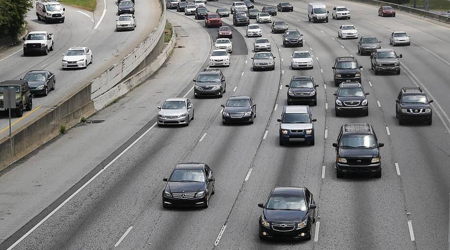

In [ ]:
import cv2
import requests
import numpy as np
from PIL import Image

image = Image.open(requests.get('https://a57.foxnews.com/media.foxbusiness.com/BrightCove/854081161001/201805/2879/931/524/854081161001_5782482890001_5782477388001-vs.jpg', stream=True).raw)
image = image.resize((450,250))
image_arr = np.array(image)
image

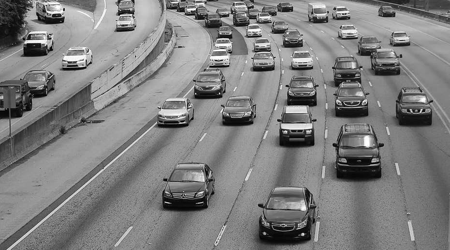

In [ ]:
#GrayScale
grey = cv2.cvtColor(image_arr,cv2.COLOR_BGR2GRAY)
Image.fromarray(grey)

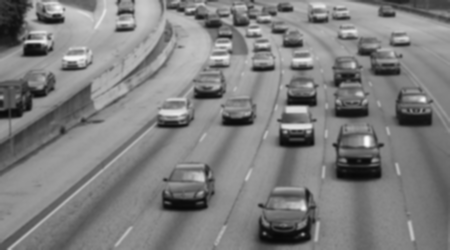

In [ ]:
# Gaussian Blur
blur = cv2.GaussianBlur(grey,(5,5),0)
Image.fromarray(blur)

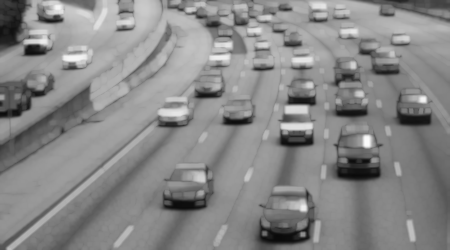

In [ ]:
# Dilation
dilated = cv2.dilate(blur,np.ones((3,3)))
Image.fromarray(dilated)

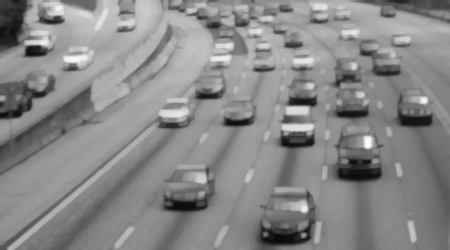

In [ ]:
# Morphology-Ex, structuring element
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
Image.fromarray(closing)

In [ ]:
!wget https://raw.githubusercontent.com/andrewssobral/vehicle_detection_haarcascades/master/cars.xml

In [ ]:
car_cascade_src = '/content/cars.xml'
car_cascade = cv2.CascadeClassifier(car_cascade_src)
cars = car_cascade.detectMultiScale(closing, 1.1, 1)
cars

array([[376,   1,  22,  22],
       [245,  24,  20,  20],
       [307,   4,  27,  27],
       [196,  10,  28,  28],
       [ 35,   2,  30,  30],
       [274,  22,  37,  37],
       [250,  35,  25,  25],
       [ 13,  25,  43,  43],
       [101,   3,  43,  43],
       [ 62,  39,  23,  23],
       [224,  32,  30,  30],
       [ 52,  44,  39,  39],
       [237,  38,  49,  49],
       [362,  43,  46,  46],
       [256,  52,  79,  79],
       [317,  66,  66,  66],
       [209,  88,  54,  54],
       [384,  84,  59,  59],
       [145,  91,  53,  53],
       [268, 106,  60,  60],
       [318, 121,  82,  82],
       [150, 163,  68,  68]], dtype=int32)

22  cars found


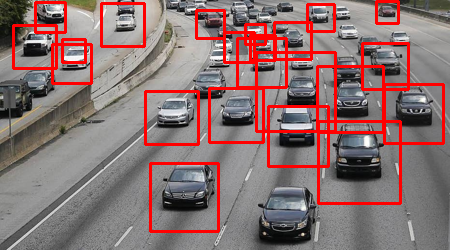

In [ ]:
cnt = 0
for (x,y,w,h) in cars:
    cv2.rectangle(image_arr,(x,y),(x+w,y+h),(255,0,0),2)
    cnt += 1
print(cnt, " cars found")
Image.fromarray(image_arr)

#[4](https://www.analyticsvidhya.com/blog/2022/04/building-vehicle-counter-system-using-opencv/)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
!git clone https://github.com/Abhishekjl/OPENCV-.git

Cloning into 'OPENCV-'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 14.68 MiB | 14.08 MiB/s, done.


In [ ]:
import math
class EuclideanDistTracker:
    def __init__(self):
        # Storing the positions of center of the objects
        self.center_points = {}
        # Count of ID of boundng boxes
        # each time new object will be captured the id will be increassed by 1
        self.id_count = 0
    def update(self, objects_rect):
        objects_bbs_ids = []
        # Calculating the center of objects
        for rect in objects_rect:
            x, y, w, h = rect
            center_x = (x + x + w) // 2
            center_y = (y + y + h) // 2
            # Find if object is already detected or not
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(center_x - pt[0], center_y - pt[1])
                if dist < 25:
                    self.center_points[id] = (center_x, center_y)
                    print(self.center_points)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break
            # Assign the ID to the detected object
            if same_object_detected is False:
               self.center_points[self.id_count] = (center_x, center_y)
               objects_bbs_ids.append([x, y, w, h, self.id_count])
               self.id_count += 1
        # Cleaning the dictionary ids that are not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            var,var,var,var, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center
       # Updating the dictionary with IDs that is not used

        self.center_points = new_center_points.copy()

        return objects_bbs_ids

In [ ]:
import cv2
import numpy as np
tracker = EuclideanDistTracker()
cap  = cv2.VideoCapture('/content/OPENCV-/highway.mp4')
ret, frame1 = cap.read()
ret, frame2 = cap.read()
ret

True

In [ ]:
video = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'mp4v') , 1, (width, height))

while cap.isOpened():
    # ret, frame = cap.read()
    diff = cv2.absdiff(frame1, frame2)
    # this method is used to find the difference bw two  frames
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0 )
    # here i would add the region of interest to count the single lane cars
    height, width = blur.shape
    print(height, width)
    # thresh_value = cv2.getTrackbarPos('thresh', 'trackbar')
    _, threshold = cv2.threshold(blur, 23, 255, cv2.THRESH_BINARY)
    dilated = cv2.dilate(threshold, (1,1), iterations=1)
    contours, _, = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []
    # DRAWING RECTANGLE BOX (Bounding Box)
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) <300:
            continue
        detections.append([x,y,w,h])
    boxes_ids = tracker.update(detections)
    for box_id in boxes_ids:
        x,y,w,h,id = box_id
        cv2.putText(frame1, str(id),(x,y-15),  cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
        cv2.rectangle(frame1, (x,y),(x+w, y+h), (0,255,0), 2)
        video.write(frame1)
        # cv2_imshow(frame1)
    frame1 = frame2
    ret, frame2 = cap.read()
    key = cv2.waitKey(30)
    if key == ord('q'):
        break
cv2.destroyAllWindows()
video.release()

#[building-crowd-counting-model-python](https://github.com/NeuroSYS-pl/objects_counting_dmap)

In [ ]:
import os
import torch
import IPython
import numpy as np
import pandas as pd
IPython.display.clear_output()

In [ ]:
!git clone https://github.com/NeuroSYS-pl/objects_counting_dmap.git
!wget https://personal.ie.cuhk.edu.hk/~ccloy/files/datasets/mall_dataset.zip
!unzip *.zip && rm *.zip
IPython.display.clear_output()

In [ ]:
"""A tool to download and preprocess data, and generate HDF5 file.

Available datasets:

    * cell: http://www.robots.ox.ac.uk/~vgg/research/counting/index_org.html
    * mall: http://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html
    * ucsd: http://www.svcl.ucsd.edu/projects/peoplecnt/
"""
import os
import shutil
import zipfile
from glob import glob
from typing import List, Tuple

import click
import h5py
import numpy as np
from PIL import Image
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter


@click.command()
@click.option('--dataset',
              type=click.Choice(['cell', 'mall', 'ucsd']),
              required=True)
def get_data(dataset: str):
    {
        'cell': generate_cell_data,
        'mall': generate_mall_data,
        'ucsd': generate_ucsd_data
    }[dataset]()


def create_hdf5(dataset_name, train_size, valid_size, img_size, in_channels=3):

    # create output folder if it does not exist
    os.makedirs(dataset_name, exist_ok=True)

    # create HDF5 files: [dataset_name]/(train | valid).h5
    train_h5 = h5py.File(os.path.join(dataset_name, 'train.h5'), 'w')
    valid_h5 = h5py.File(os.path.join(dataset_name, 'valid.h5'), 'w')

    # add two HDF5 datasets (images and labels) for each HDF5 file
    for h5, size in ((train_h5, train_size), (valid_h5, valid_size)):
        h5.create_dataset('images', (size, in_channels, *img_size))
        h5.create_dataset('labels', (size, 1, *img_size))

    return train_h5, valid_h5


def generate_label(label_info: np.array, image_shape: List[int]):
    label = np.zeros(image_shape, dtype=np.float32)

    for x, y, *_ in label_info:
        if y < image_shape[0] and x < image_shape[1]:
            label[int(y)][int(x)] = 100

    # apply a convolution with a Gaussian kernel
    label = gaussian_filter(label, sigma=(1, 1), order=0)

    return label

def generate_ucsd_data():
    """Generate HDF5 files for mall dataset."""
    # download and extract data
    get_and_unzip(
        'http://www.svcl.ucsd.edu/projects/peoplecnt/db/ucsdpeds.zip'
    )
    # download and extract annotations
    get_and_unzip(
        'http://www.svcl.ucsd.edu/projects/peoplecnt/db/vidf-cvpr.zip'
    )
    # create training and validation HDF5 files
    train_h5, valid_h5 = create_hdf5('ucsd',
                                     train_size=1500,
                                     valid_size=500,
                                     img_size=(160, 240),
                                     in_channels=1)

    def fill_h5(h5, labels, video_id, init_frame=0, h5_id=0):
        """
        Save images and labels in given HDF5 file.

        Args:
            h5: HDF5 file
            labels: the list of labels
            video_id: the id of a scene
            init_frame: the first frame in given list of labels
            h5_id: next dataset id to be used
        """
        video_name = f"vidf1_33_00{video_id}"
        video_path = f"ucsdpeds/vidf/{video_name}.y/"

        for i, label in enumerate(labels, init_frame):
            # path to the next frame (convention: [video name]_fXXX.jpg)
            img_path = f"{video_path}/{video_name}_f{str(i+1).zfill(3)}.png"

            # get an image as numpy array
            image = np.array(Image.open(img_path), dtype=np.float32) / 255
            # generate a density map by applying a Gaussian filter
            label = generate_label(label[0][0][0], image.shape)

            # pad images to allow down and upsampling
            image = np.pad(image, 1, 'constant', constant_values=0)
            label = np.pad(label, 1, 'constant', constant_values=0)

            # save data to HDF5 file
            h5['images'][h5_id + i - init_frame, 0] = image
            h5['labels'][h5_id + i - init_frame, 0] = label

    # dataset contains 10 scenes
    for scene in range(10):
        # load labels infomation from provided MATLAB file
        # it is numpy array with (x, y) objects position for subsequent frames
        descriptions = loadmat(f'vidf-cvpr/vidf1_33_00{scene}_frame_full.mat')
        labels = descriptions['frame'][0]

        # use first 150 frames for training and the last 50 for validation
        # start filling from the place last scene finished
        fill_h5(train_h5, labels[:150], scene, 0, 150 * scene)
        fill_h5(valid_h5, labels[150:], scene, 150, 50 * scene)

    # close HDF5 files
    train_h5.close()
    valid_h5.close()

    # cleanup
    shutil.rmtree('ucsdpeds')
    shutil.rmtree('vidf-cvpr')


def generate_mall_data():
    """Generate HDF5 files for mall dataset."""
    # download and extract dataset
    get_and_unzip(
        'http://personal.ie.cuhk.edu.hk/~ccloy/files/datasets/mall_dataset.zip'
    )
    # create training and validation HDF5 files
    train_h5, valid_h5 = create_hdf5('mall',
                                     train_size=1500,
                                     valid_size=500,
                                     img_size=(480, 640),
                                     in_channels=3)

    # load labels infomation from provided MATLAB file
    # it is a numpy array with (x, y) objects position for subsequent frames
    labels = loadmat('mall_dataset/mall_gt.mat')['frame'][0]

    def fill_h5(h5, labels, init_frame=0):
        """
        Save images and labels in given HDF5 file.

        Args:
            h5: HDF5 file
            labels: the list of labels
            init_frame: the first frame in given list of labels
        """
        for i, label in enumerate(labels, init_frame):
            # path to the next frame (filename convention: seq_XXXXXX.jpg)
            img_path = f"mall_dataset/frames/seq_{str(i+1).zfill(6)}.jpg"

            # get an image as numpy array
            image = np.array(Image.open(img_path), dtype=np.float32) / 255
            image = np.transpose(image, (2, 0, 1))

            # generate a density map by applying a Gaussian filter
            label = generate_label(label[0][0][0], image.shape[1:])

            # save data to HDF5 file
            h5['images'][i - init_frame] = image
            h5['labels'][i - init_frame, 0] = label

    # use first 1500 frames for training and the last 500 for validation
    fill_h5(train_h5, labels[:1500])
    fill_h5(valid_h5, labels[1500:], 1500)

    # close HDF5 file
    train_h5.close()
    valid_h5.close()

    # cleanup
    shutil.rmtree('mall_dataset')


def generate_cell_data():
    """Generate HDF5 files for fluorescent cell dataset."""
    # download and extract dataset
    get_and_unzip(
        'http://www.robots.ox.ac.uk/~vgg/research/counting/cells.zip',
        location='cells'
    )
    # create training and validation HDF5 files
    train_h5, valid_h5 = create_hdf5('cell',
                                     train_size=150,
                                     valid_size=50,
                                     img_size=(256, 256),
                                     in_channels=3)

    # get the list of all samples
    # dataset name convention: XXXcell.png (image) XXXdots.png (label)
    image_list = glob(os.path.join('cells', '*cell.*'))
    image_list.sort()

    def fill_h5(h5, images):
        """
        Save images and labels in given HDF5 file.

        Args:
            h5: HDF5 file
            images: the list of images paths
        """
        for i, img_path in enumerate(images):
            # get label path
            label_path = img_path.replace('cell.png', 'dots.png')
            # get an image as numpy array
            image = np.array(Image.open(img_path), dtype=np.float32) / 255
            image = np.transpose(image, (2, 0, 1))

            # convert a label image into a density map: dataset provides labels
            # in the form on an image with red dots placed in objects position

            # load an RGB image
            label = np.array(Image.open(label_path))
            # make a one-channel label array with 100 in red dots positions
            label = 100.0 * (label[:, :, 0] > 0)
            # generate a density map by applying a Gaussian filter
            label = gaussian_filter(label, sigma=(1, 1), order=0)

            # save data to HDF5 file
            h5['images'][i] = image
            h5['labels'][i, 0] = label

    # use first 150 samples for training and the last 50 for validation
    fill_h5(train_h5, image_list[:150])
    fill_h5(valid_h5, image_list[150:])

    # close HDF5 files
    train_h5.close()
    valid_h5.close()

    # cleanup
    shutil.rmtree('cells')

if __name__ == '__main__':
    get_data()

In [ ]:
"""PyTorch dataset for HDF5 files generated with `get_data.py`."""
import os
from random import random
from typing import Optional

import h5py
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader


class H5Dataset(Dataset):
    """PyTorch dataset for HDF5 files generated with `get_data.py`."""

    def __init__(self,
                 dataset_path: str,
                 horizontal_flip: float=0.0,
                 vertical_flip: float=0.0):
        """
        Initialize flips probabilities and pointers to a HDF5 file.

        Args:
            dataset_path: a path to a HDF5 file
            horizontal_flip: the probability of applying horizontal flip
            vertical_flip: the probability of applying vertical flip
        """
        super(H5Dataset, self).__init__()
        self.h5 = h5py.File(dataset_path, 'r')
        self.images = self.h5['images']
        self.labels = self.h5['labels']
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip

    def __len__(self):
        """Return no. of samples in HDF5 file."""
        return len(self.images)

    def __getitem__(self, index: int):
        """Return next sample (randomly flipped)."""
        # if both flips probabilities are zero return an image and a label
        if not (self.horizontal_flip or self.vertical_flip):
            return self.images[index], self.labels[index]

        # axis = 1 (vertical flip), axis = 2 (horizontal flip)
        axis_to_flip = []

        if random() < self.vertical_flip:
            axis_to_flip.append(1)

        if random() < self.horizontal_flip:
            axis_to_flip.append(2)

        return (np.flip(self.images[index], axis=axis_to_flip).copy(),
                np.flip(self.labels[index], axis=axis_to_flip).copy())


# --- PYTESTS --- #

def test_loader():
    """Test HDF5 dataloader with flips on and off."""
    run_batch(flip=False)
    run_batch(flip=True)


def run_batch(flip):
    """Sanity check for HDF5 dataloader checks for shapes and empty arrays."""
    # datasets to test loader on
    datasets = {
        'cell': (3, 256, 256),
        'mall': (3, 480, 640),
        'ucsd': (1, 160, 240)
    }

    # for each dataset check both training and validation HDF5
    # for each one check if shapes are right and arrays are not empty
    for dataset, size in datasets.items():
        for h5 in ('train.h5', 'valid.h5'):
            # create a loader in "all flips" or "no flips" mode
            data = H5Dataset(os.path.join(dataset, h5),
                             horizontal_flip=1.0 * flip,
                             vertical_flip=1.0 * flip)
            # create dataloader with few workers
            data_loader = DataLoader(data, batch_size=4, num_workers=4)

            # take one batch, check samples, and go to the next file
            for img, label in data_loader:
                # image batch shape (#workers, #channels, resolution)
                assert img.shape == (4, *size)
                # label batch shape (#workers, 1, resolution)
                assert label.shape == (4, 1, *size[1:])

                assert torch.sum(img) > 0
                assert torch.sum(label) > 0

                break

#[dddd](https://www.kaggle.com/datasets/fmena14/crowd-counting/code?datasetId=81645&sortBy=voteCount)


https://personal.ie.cuhk.edu.hk/~ccloy/files/datasets/mall_dataset.zip

In [4]:
import os
import cv2
import IPython
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import model_selection

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d fmena14/crowd-counting
!unzip \*.zip && rm *.zip
IPython.display.clear_output()

In [6]:
!wget https://personal.ie.cuhk.edu.hk/~ccloy/files/datasets/mall_dataset.zip
!unzip \*.zip && rm *.zip
IPython.display.clear_output()

In [ ]:
path = '/content/frames/frames/'
# data = []
# IMAGE_SIZE = (480, 640)
# for i in os.listdir(path):
#   img = cv2.imread(path+i)
#   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   img = img/255
#   data.append(img)

tf.keras.utils.image_dataset_from_directory(path,
                                            labels='inferred',
                                            color_mode='bgr',
                                            batch_size=32,
                                            image_size=(480, 640),
                                            shuffle=True,
                                            seed=32)

In [ ]:
labels = pd.read_csv('./labels.csv', index_col='id')
# labels

In [ ]:
img = np.load('./images.npy')
# img.shape

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    zoom_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.2,

    # This one is important:
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

In [ ]:
df = pd.read_csv('./labels.csv')

df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)
df

,id,count,image_name
0,1,35,seq_000001.jpg
1,2,41,seq_000002.jpg
2,3,41,seq_000003.jpg
3,4,44,seq_000004.jpg
4,5,41,seq_000005.jpg
...,...,...,...
1995,1996,27,seq_001996.jpg
1996,1997,27,seq_001997.jpg
1997,1998,25,seq_001998.jpg
1998,1999,26,seq_001999.jpg


In [ ]:
df.describe()

,id,count
count,2000.000000,2000.000000
mean,1000.500000,31.157500
std,577.494589,6.945417
min,1.000000,13.000000
25%,500.750000,26.000000
50%,1000.500000,31.000000
75%,1500.250000,36.000000
max,2000.000000,53.000000


<Axes: >

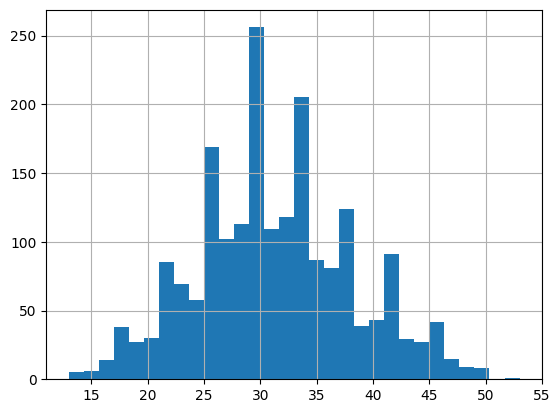

In [ ]:
df['count'].hist(bins=30)

In [ ]:
labels = np.array(df['count'])
labels

array([35, 41, 41, ..., 25, 26, 26])

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (480, 640, 3)

flow_params = dict(
    dataframe=df,
    directory='./frames/frames',
    x_col="image_name",
    y_col="count",
    weight_col=None,
    target_size=IMAGE_SIZE[:2],
    color_mode='rgb',
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=32,
)

# The dataset is split to training and validation sets at this point
train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)

Found 1600 validated image filenames.
Found 400 validated image filenames.


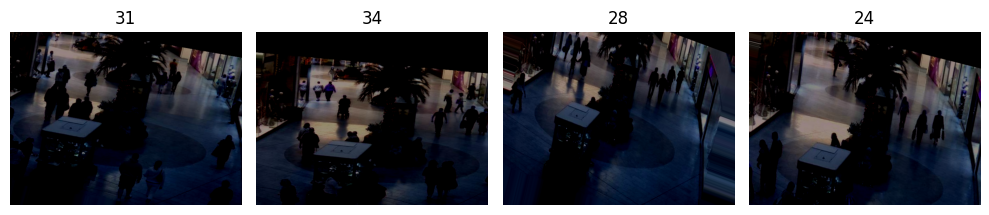

In [ ]:
batch = next(train_generator)
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes = axes.flatten()
for i in range(4):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=IMAGE_SIZE, pooling='avg')

x = base_model.output
x = tf.keras.layers.Dense(1024, activation='relu')(x)
model_output = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=model_output)

model.summary()

In [ ]:
k = -7
for id, layer in enumerate(model.layers):
  layer.trainable=False if id < k else True

In [ ]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error', 'mean_squared_error'])


lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1,
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [ ]:
history = model.fit(train_generator,
                     epochs=10,
                     validation_data=valid_generator,
                     verbose=2,
                     callbacks=[lr_scheduler])

Epoch 1/10


#5

In [ ]:
import os
import random
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 10
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 1e-3
IMAGE_SIZE = 299
def load_image(is_labelled: bool, is_training=True):
    """Wrapper function that returns a function
    for loading a single image if is_labelled=False
    or a function for loading image in an image-label pair
    if is_labelled=True.
    :param is_labelled: Boolean argument defining the return
    :param is_training: Boolean argument for image augmentation
    :return: Function
    """
    def _get_image(path: str) -> tf.Tensor:
        """Function loads image from a file.
        :param path: Path to image file
        :return: Tensor with preprocessed image
        """
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        image = tf.cast(image, dtype=tf.int32)
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
        if is_training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.1, 0.2)
            image = tf.image.random_saturation(image, 0.9, 1.1)
            image = tf.image.random_hue(image, 0.1)
        return tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    def _get_image_label(img: tf.Tensor, label: int) -> tuple:
        """Function loads the image in an image-label pair.
        :param img: Tensor with original image
        :param label: Target value
        :return: Tuple with TF tensor and label
        """
        return _get_image(img), label

    return _get_image_label if is_labelled else _get_image


def prepare_dataset(dataset, is_training=True, is_labeled=True):
    """Function transforms a TF dataset containing file paths
    or file paths and labels to a dataset with image tensors and labels.
    :param dataset: Original dataset
    :param is_training: Argument defines if shuffling and image augmentation should be applied
    :param is_labeled: Argument defines if the dataset contains labels
    :return: Updated dataset
    """
    image_read_fn = load_image(is_labeled, is_training)
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)


def create_model() -> tf.keras.Model:
    """Function initializes and compiles a regression model
    with pretrained feature extractor.
    :return: TF Model object
    """
    feature_model = tf.keras.applications.InceptionResNetV2(
        include_top=False, pooling='avg')
    feature_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        feature_model,
        tf.keras.layers.Dense(512, activation='selu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model


def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    mae = hist.history['mean_absolute_error']
    val_mae = hist.history['val_mean_absolute_error']
    x_axis = range(1, len(mae) + 1)
    plt.plot(x_axis, mae, 'bo', label='Training')
    plt.plot(x_axis, val_mae, 'ro', label='Validation')
    plt.title('MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()


def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()
# Create train and validation data sets.
data_train = data.head(1700)
data_valid = data.tail(300)

ds_train = tf.data.Dataset.from_tensor_slices((data_train['path'], data_train['count']))
ds_valid = tf.data.Dataset.from_tensor_slices((data_valid['path'], data_valid['count']))

ds_train = prepare_dataset(ds_train)
ds_valid = prepare_dataset(ds_valid, is_training=False)
# Load the model.
model = create_model()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE,
    restore_best_weights=True)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=1, cooldown=1, verbose=1,
    factor=0.75, min_lr=1e-8)

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=EPOCHS, callbacks=[early_stop, lr_reduction],
                    use_multiprocessing=True, workers=os.cpu_count())

#FastAi

In [2]:
import numpy as np
import pandas as pd
import fastai
fastai.__version__

'2.7.13'

In [7]:
from fastai.vision.all import *
path = './frames/frames/'

Path(path).ls()[:3]

(#3) [Path('frames/frames/seq_000975.jpg'),Path('frames/frames/seq_001380.jpg'),Path('frames/frames/seq_000147.jpg')]

In [15]:
df = pd.read_csv('./labels.csv')
df.head()

,id,count
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41


In [16]:
df['id'] = df.id.apply(lambda x: './frames/frames/seq_{:06d}.jpg'.format(x))
df.columns = ['x','y']
df.head()

,x,y
0,./frames/frames/seq_000001.jpg,35
1,./frames/frames/seq_000002.jpg,41
2,./frames/frames/seq_000003.jpg,41
3,./frames/frames/seq_000004.jpg,44
4,./frames/frames/seq_000005.jpg,41


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


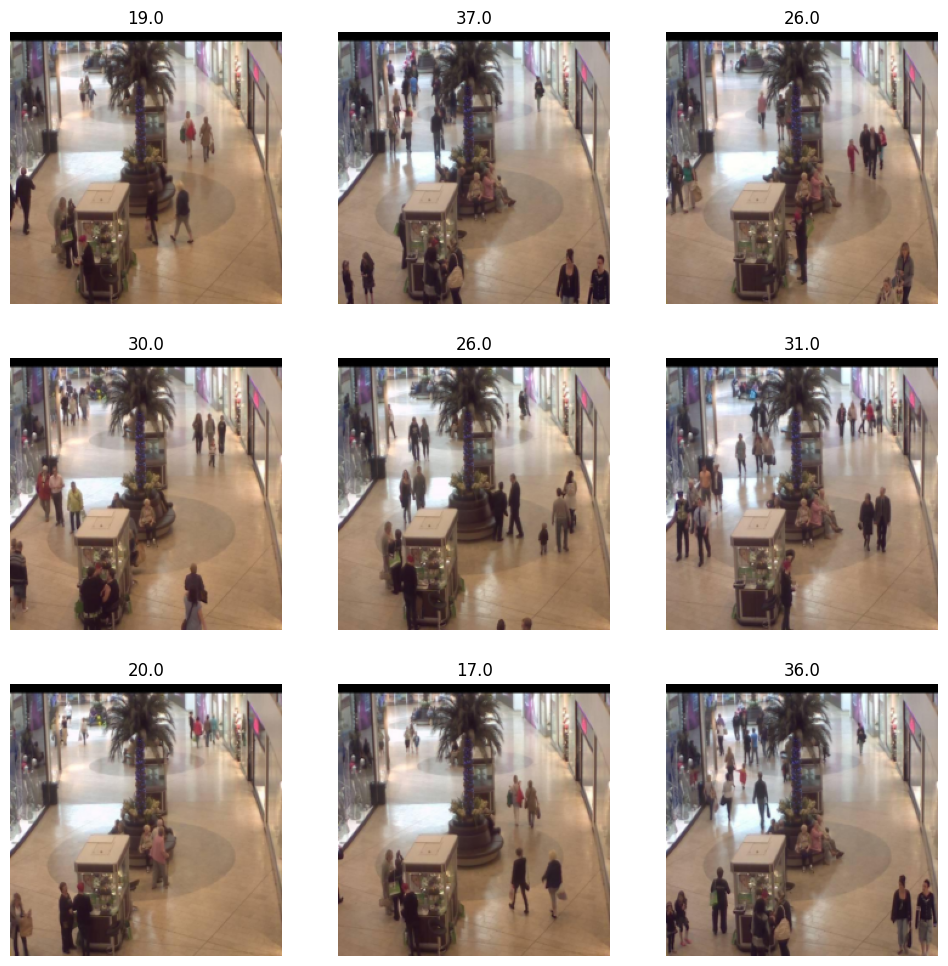

In [17]:
def get_x(df): return df['x'] # path to images
def get_y(df): return df['y'] # labels

d = DataBlock(blocks=(ImageBlock, RegressionBlock),    # types of input and output
         get_x = get_x,                                # function to get path to images
         get_y = get_y,                                # function fo get labels
         splitter=RandomSplitter(),                    # random splitter (20% for validation)
         item_tfms=Resize(224, ResizeMethod.Squish),)  # resize and squish images

dl = d.dataloaders(df)

len(dl.train_ds), len(dl.valid_ds)
(1600, 400)

dl.show_batch(figsize=(12,12))

In [ ]:
learn = cnn_learner(dl, resnet18, metrics=mae)
learn.fine_tune(8, 5e-2)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 45.7MB/s]


epoch,train_loss,valid_loss,mae,time
